# Hands-on with Spark

![spark](https://cdn-images-1.medium.com/max/300/1*c8CtvqKJDVUnMoPGujF5fA.png)

PySpark is the Python API of Spark; which means it can do almost all the things python can- Machine learning (ML), exploratory data analysis (EDA), ETLs for data platform. And all of them in a distributed manner.

![pyspark](https://editor.analyticsvidhya.com/uploads/20981sp3.JPG)

In simple terms, each time you submit a PySpark job, the code gets internally converted into a MapReduce program and gets executed in the Java Virtual Machine. Spark also uses Lazy Evaluation, it delays its evaluation as much as it can. Each time you submit a job, spark creates an action plan for how to execute the code, and then does nothing. Finally, when you ask for the result (i.e, calls an action), it executes the plan, which is basically all the transofrmations you have mentioned in your code.


For our lesson, we will be running Spark on **local** mode.

In this mode, Spark runs on a single machine, utilizing available cores (similar to Polars).
It's useful for development, learning, testing, and debugging since everything runs on the local machine without needing a cluster.

In actual production environments, Spark is usually run on a cluster of machines (YARN, Mesos or Kubernetes mode).

## Installing and Initializing Spark

First, we'll need to install Spark and its dependencies:

1.   Java 8
2.   Apache Spark with Hadoop
3.   Findspark (used to locate the Spark in the system)


In [1]:
# changelog 20251207 Alvin - update apt for new location of openjdk-8-jdk-headless package
#!sudo apt update

In [2]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# # Either retrieve from archive https://archive.apache.org/dist/spark/spark-3.5.5/ or from latest https://spark.apache.org/downloads.html
# #!wget -q https://downloads.apache.org/spark/spark-3.5.6/spark-3.5.6-bin-hadoop3.tgz
# !wget -q https://dlcdn.apache.org/spark/spark-3.5.7/spark-3.5.7-bin-hadoop3.tgz
# !tar xf spark-3.5.7-bin-hadoop3.tgz
# !pip install -q findspark

List the files in the current directory:

In [3]:
#!ls

*Print* the current directory:

In [4]:
#!pwd

Set the OS Environment Variables so that Findspark can locate Spark in the system:

In [5]:
# This sets the environment variables in Colab environment
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.5.7-bin-hadoop3"

In [6]:
#This line initializes findspark, which helps locate and set up the Spark environment in your system. This is necessary so that PySpark can be used.
import findspark
findspark.init()

In [7]:
#SparkSession.builder provides a way to configure the session, and .getOrCreate() either gets an existing SparkSession if one is already running or creates a new one.
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/09 18:11:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Invoking `spark` will print the SparkContext

In [8]:
spark

## Spark SQL and DataFrames

Spark SQL and DataFrames are higher-level modules of Apache Spark, they work together to make data processing with Spark more intuitive and optimized, especially for those who come from an SQL or data analytics background.

- **SQL Interface to Spark**: Spark SQL lets users execute SQL queries alongside Spark programs.

- **DataFrames are abstraction over RDDs**: A DataFrame is a distributed collection of data organized into named columns. Conceptually, it's equivalent to a table in a relational database or a data frame in R or Python, but with optimizations for distributed processing and scalability. While RDD (Resilient Distributed Dataset) is a fundamental data structure in Spark, DataFrames provide a higher-level abstraction that is often easier to use and more optimized for many tasks.

### DataFrame Creation

In [9]:
from datetime import datetime, date
import pandas as pd
from pyspark.sql import Row

In [10]:
df = spark.createDataFrame([
    Row(a=1, b=2., c='string1', d=date(2000, 1, 1), e=datetime(2000, 1, 1, 12, 0)),
    Row(a=2, b=3., c='string2', d=date(2000, 2, 1), e=datetime(2000, 1, 2, 12, 0)),
    Row(a=4, b=5., c='string3', d=date(2000, 3, 1), e=datetime(2000, 1, 3, 12, 0))
])
df

DataFrame[a: bigint, b: double, c: string, d: date, e: timestamp]

PySpark infers the DataFrame schema (dtypes) by taking a sample from the data (just like Pandas)

In [11]:
df.show(5)

+---+---+-------+----------+-------------------+
|  a|  b|      c|         d|                  e|
+---+---+-------+----------+-------------------+
|  1|2.0|string1|2000-01-01|2000-01-01 12:00:00|
|  2|3.0|string2|2000-02-01|2000-01-02 12:00:00|
|  4|5.0|string3|2000-03-01|2000-01-03 12:00:00|
+---+---+-------+----------+-------------------+




You can also pass an explicit schema:

In [12]:
df = spark.createDataFrame([
    (1, 2., 'string1', date(2000, 1, 1), datetime(2000, 1, 1, 12, 0)),
    (2, 3., 'string2', date(2000, 2, 1), datetime(2000, 1, 2, 12, 0)),
    (3, 4., 'string3', date(2000, 3, 1), datetime(2000, 1, 3, 12, 0))
], schema='a long, b double, c string, d date, e timestamp')
df

DataFrame[a: bigint, b: double, c: string, d: date, e: timestamp]

PySpark DataFrame is lazily evaluated and invoking `df` does not trigger the computation and show anything. You need to explicitly call the `show` method:

In [13]:
df.show()
df.printSchema()

+---+---+-------+----------+-------------------+
|  a|  b|      c|         d|                  e|
+---+---+-------+----------+-------------------+
|  1|2.0|string1|2000-01-01|2000-01-01 12:00:00|
|  2|3.0|string2|2000-02-01|2000-01-02 12:00:00|
|  3|4.0|string3|2000-03-01|2000-01-03 12:00:00|
+---+---+-------+----------+-------------------+

root
 |-- a: long (nullable = true)
 |-- b: double (nullable = true)
 |-- c: string (nullable = true)
 |-- d: date (nullable = true)
 |-- e: timestamp (nullable = true)



### Getting Data In/Out

There are many data sources available in PySpark such as CSV, Parquet, ORC, JDBC, text, Avro, etc.

First, let's download the files in various format from GCS, data which we explored in Unit 2.3 and 2.8.

In [14]:
#!mkdir -p data

In [15]:
# check if the
# !wget -P data https://storage.googleapis.com/su-artifacts/movies_metadata.csv
# !wget -P data https://storage.googleapis.com/su-artifacts/ratings.csv
# !wget -P data https://storage.googleapis.com/su-artifacts/taxi_trip_data.csv
# !wget -P data https://storage.googleapis.com/su-artifacts/userdata1.orc
# !wget -P data https://storage.googleapis.com/su-artifacts/userdata1.parquet

In [16]:
#!ls data

In [17]:
df = spark.read.parquet('data/userdata1.parquet')
df.show()

+-------------------+---+----------+---------+--------------------+------+---------------+-------------------+--------------------+----------+---------+--------------------+--------------------+
|  registration_dttm| id|first_name|last_name|               email|gender|     ip_address|                 cc|             country| birthdate|   salary|               title|            comments|
+-------------------+---+----------+---------+--------------------+------+---------------+-------------------+--------------------+----------+---------+--------------------+--------------------+
|2016-02-03 15:55:29|  1|    Amanda|   Jordan|    ajordan0@com.com|Female|    1.197.201.2|   6759521864920116|           Indonesia|  3/8/1971| 49756.53|    Internal Auditor|               1E+02|
|2016-02-04 01:04:03|  2|    Albert|  Freeman|     afreeman1@is.gd|  Male| 218.111.175.34|                   |              Canada| 1/16/1968|150280.17|       Accountant IV|                    |
|2016-02-03 09:09:31|  3|

In [18]:
df = spark.read.orc('data/userdata1.orc')
df.show()

+-------------------+-----+--------+---------+--------------------+------+---------------+----------------+--------------------+----------+---------+--------------------+------+
|              _col0|_col1|   _col2|    _col3|               _col4| _col5|          _col6|           _col7|               _col8|     _col9|   _col10|              _col11|_col12|
+-------------------+-----+--------+---------+--------------------+------+---------------+----------------+--------------------+----------+---------+--------------------+------+
|2016-02-03 13:36:39|    1|  Donald|    Lewis|dlewis0@clickbank...|  Male|  102.22.124.20|                |           Indonesia|  7/9/1972|140249.37|Senior Financial ...|      |
|2016-02-03 00:22:28|    2|  Walter|  Collins|wcollins1@bloglov...|  Male|   247.28.26.93|3587726269478025|               China|          |     NULL|                    |      |
|2016-02-03 18:29:04|    3|Michelle|Henderson|mhenderson2@geoci...|Female| 193.68.146.150|                |   

In [19]:
movies = spark.read.csv('data/movies_metadata.csv', header=True)
ratings = spark.read.csv('data/ratings.csv', header=True)
taxi = spark.read.csv('data/taxi_trip_data.csv', header=True)

In [20]:
movies.printSchema()

root
 |-- adult: string (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- video: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nu

In [21]:
ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [22]:
taxi.printSchema()

root
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- imp_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- pickup_location_id: string (nullable = true)
 |-- dropoff_location_id: string (nullable = true)



In [23]:
movies = spark.read.csv('data/movies_metadata.csv', header=True, inferSchema=True, quote="\"", escape="\"")

In [24]:
movies.printSchema()

root
 |-- adult: string (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- video: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nu

In [25]:
ratings = spark.read.csv('data/ratings.csv', header=True, inferSchema=True)

In [26]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



Passing a schema will speed up the read.

In [27]:
dtypes = ['vendor_id integer',
 'pickup_datetime timestamp',
 'dropoff_datetime timestamp',
 'passenger_count integer',
 'trip_distance double',
 'rate_code integer',
 'store_and_fwd_flag string',
 'payment_type integer',
 'fare_amount double',
 'extra double',
 'mta_tax double',
 'tip_amount double',
 'tolls_amount double',
 'imp_surcharge double',
 'total_amount double',
 'pickup_location_id integer',
 'dropoff_location_id integer']

In [28]:
taxi = spark.read.csv('data/taxi_trip_data.csv', header=True, schema=', '.join(dtypes))

In [29]:
taxi.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- imp_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_location_id: integer (nullable = true)
 |-- dropoff_location_id: integer (nullable = true)



There are a couple of ways to view your dataframe in PySpark:

1.   `df.take(5)` will return a list of five Row objects.
2.   `df.collect()` will get all of the data from the entire DataFrame. Be really careful when using it, because if you have a large data set, you can easily crash the driver node.
3.   `df.show()` is the most commonly used method to view a dataframe. There are a few parameters we can pass to this method, like the number of rows and truncaiton. For example, `df.show(5, False)` or ` df.show(5, truncate=False)` will show the entire data wihtout any truncation.
4.   `df.limit(5)` will **return a new DataFrame** by taking the first n rows. As spark is distributed in nature, there is no guarantee that `df.limit()` will give you the same results each time.

In [30]:
movies.show(10)

+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+---------+-------+--------------------+--------+--------------------+--------------------+-----+------------+----------+
|adult|belongs_to_collection|  budget|              genres|            homepage|   id|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|  revenue|runtime|    spoken_languages|  status|             tagline|               title|video|vote_average|vote_count|
+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+---------+-------+-----------

In [31]:
movies.show(5, truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+-------------------------------------------------------------------------------------------------+------------------------------------+-----+---------+-----------------+---------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------------------------------+-----------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------

In [32]:
# can also be shown vertically
movies.show(1, vertical=True, truncate=False)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 adult                 | False                                                                                                                                                                                                                                                                                                           
 belongs_to_collection | {'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}                                                                                                                                                           
 budget   

In [33]:
ratings.show(10)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    110|   1.0|1425941529|
|     1|    147|   4.5|1425942435|
|     1|    858|   5.0|1425941523|
|     1|   1221|   5.0|1425941546|
|     1|   1246|   5.0|1425941556|
|     1|   1968|   4.0|1425942148|
|     1|   2762|   4.5|1425941300|
|     1|   2918|   5.0|1425941593|
|     1|   2959|   4.0|1425941601|
|     1|   4226|   4.0|1425942228|
+------+-------+------+----------+
only showing top 10 rows



In [34]:
taxi.show(10)

+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|total_amount|pickup_location_id|dropoff_location_id|
+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+
|        2|2018-03-29 13:37:13|2018-03-29 14:17:01|              1|        18.15|        3|                 N|           1|       70.0|  0.0|    0.0|     16.16|        10.5|          0.3|       96.96|               161|                  1|
|        2|2018-03-29 13:37:18|2018-03-2

In [35]:
taxi.limit(5).show()

+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|total_amount|pickup_location_id|dropoff_location_id|
+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+
|        2|2018-03-29 13:37:13|2018-03-29 14:17:01|              1|        18.15|        3|                 N|           1|       70.0|  0.0|    0.0|     16.16|        10.5|          0.3|       96.96|               161|                  1|
|        2|2018-03-29 13:37:18|2018-03-2

In [36]:
movies.describe().show()

25/12/09 18:11:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------------------------+--------------------+--------------------+--------------------+------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+-----+--------------------+------------------+
|summary|              adult|belongs_to_collection|              budget|              genres|            homepage|                  id|             imdb_id|original_language|                     original_title|            overview|          popularity|         poster_path|    production_companies|production_countries|        release_date|             revenue|             runtime|    spoken_languages|            status|           tagline|               title|video|        vote_average|  

In [37]:
ratings.describe().show()

+-------+-----------------+------------------+------------------+-------------------+
|summary|           userId|           movieId|            rating|          timestamp|
+-------+-----------------+------------------+------------------+-------------------+
|  count|         26024289|          26024289|          26024289|           26024289|
|   mean| 135037.090248114|15849.109677040553|3.5280903543608817|1.171258432691322E9|
| stddev|78176.19722170352| 31085.25753139175|1.0654427636662234| 2.05288870281847E8|
|    min|                1|                 1|               0.5|          789652004|
|    max|           270896|            176275|               5.0|         1501829870|
+-------+-----------------+------------------+------------------+-------------------+



In [38]:
taxi.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-----------------+------------------+--------------------+------------------+------------------+-------------------+
|summary|         vendor_id|   passenger_count|    trip_distance|         rate_code|store_and_fwd_flag|       payment_type|       fare_amount|             extra|            mta_tax|       tip_amount|      tolls_amount|       imp_surcharge|      total_amount|pickup_location_id|dropoff_location_id|
+-------+------------------+------------------+-----------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-----------------+------------------+--------------------+------------------+------------------+-------------------+
|  count|          10000000|          10000000|         10000000|          10000000|          10000000|   

### DataFrame Operations on Columns

We will go over the following in this section:

1.   Selecting a Column
2.   Selecting Multiple Columns
3.   Adding New Columns
4.   Renaming Columns
5.   Removing Columns


In [39]:
movies.id

Column<'id'>

Just like DataFrame, selecting a column is lazily evaluated and does not trigger the computation but returns a `Column` instance.

It can be used to select columns and returns another DataFrame:

In [40]:
movies.select(movies.id).show()

+-----+
|   id|
+-----+
|  862|
| 8844|
|15602|
|31357|
|11862|
|  949|
|11860|
|45325|
| 9091|
|  710|
| 9087|
|12110|
|21032|
|10858|
| 1408|
|  524|
| 4584|
|    5|
| 9273|
|11517|
+-----+
only showing top 20 rows



In [41]:
movies.select(movies.title, movies.overview).show(truncate=False)

+------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|title                         |overview                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
+------------------------------+----

Creating a new column:

In [42]:
from pyspark.sql.functions import lit

In [43]:
# lit means literal. It populates the row with the literal value given
ratings.withColumn('review', lit('Great movie!')).show(10)

+------+-------+------+----------+------------+
|userId|movieId|rating| timestamp|      review|
+------+-------+------+----------+------------+
|     1|    110|   1.0|1425941529|Great movie!|
|     1|    147|   4.5|1425942435|Great movie!|
|     1|    858|   5.0|1425941523|Great movie!|
|     1|   1221|   5.0|1425941546|Great movie!|
|     1|   1246|   5.0|1425941556|Great movie!|
|     1|   1968|   4.0|1425942148|Great movie!|
|     1|   2762|   4.5|1425941300|Great movie!|
|     1|   2918|   5.0|1425941593|Great movie!|
|     1|   2959|   4.0|1425941601|Great movie!|
|     1|   4226|   4.0|1425942228|Great movie!|
+------+-------+------+----------+------------+
only showing top 10 rows



In [44]:
ratings.withColumn('review', lit('Great movie!')) \
       .withColumn('mood', lit(5)) \
       .show(10)

+------+-------+------+----------+------------+----+
|userId|movieId|rating| timestamp|      review|mood|
+------+-------+------+----------+------------+----+
|     1|    110|   1.0|1425941529|Great movie!|   5|
|     1|    147|   4.5|1425942435|Great movie!|   5|
|     1|    858|   5.0|1425941523|Great movie!|   5|
|     1|   1221|   5.0|1425941546|Great movie!|   5|
|     1|   1246|   5.0|1425941556|Great movie!|   5|
|     1|   1968|   4.0|1425942148|Great movie!|   5|
|     1|   2762|   4.5|1425941300|Great movie!|   5|
|     1|   2918|   5.0|1425941593|Great movie!|   5|
|     1|   2959|   4.0|1425941601|Great movie!|   5|
|     1|   4226|   4.0|1425942228|Great movie!|   5|
+------+-------+------+----------+------------+----+
only showing top 10 rows



In [45]:
movies.withColumnRenamed('overview', 'summary').show(5)

+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+---------+-------+--------------------+--------+--------------------+--------------------+-----+------------+----------+
|adult|belongs_to_collection|  budget|              genres|            homepage|   id|  imdb_id|original_language|      original_title|             summary|popularity|         poster_path|production_companies|production_countries|release_date|  revenue|runtime|    spoken_languages|  status|             tagline|               title|video|vote_average|vote_count|
+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+---------+-------+-----------

In [46]:
ratings.drop('timestamp').show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|    110|   1.0|
|     1|    147|   4.5|
|     1|    858|   5.0|
|     1|   1221|   5.0|
|     1|   1246|   5.0|
|     1|   1968|   4.0|
|     1|   2762|   4.5|
|     1|   2918|   5.0|
|     1|   2959|   4.0|
|     1|   4226|   4.0|
|     1|   4878|   5.0|
|     1|   5577|   5.0|
|     1|  33794|   4.0|
|     1|  54503|   3.5|
|     1|  58559|   4.0|
|     1|  59315|   5.0|
|     1|  68358|   5.0|
|     1|  69844|   5.0|
|     1|  73017|   5.0|
|     1|  81834|   5.0|
+------+-------+------+
only showing top 20 rows



### Common Transformation Functions

In [47]:
# Functions available in PySpark
from pyspark.sql import functions
# We can use the dir function to view the available functions
print(dir(functions))

['Any', 'ArrayType', 'Callable', 'Column', 'DataFrame', 'DataType', 'Dict', 'Iterable', 'JVMView', 'List', 'Optional', 'PandasUDFType', 'PySparkTypeError', 'PySparkValueError', 'SparkContext', 'StringType', 'StructType', 'TYPE_CHECKING', 'Tuple', 'Type', 'Union', 'UserDefinedFunction', 'UserDefinedTableFunction', 'ValuesView', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_create_column_from_literal', '_create_lambda', '_create_py_udf', '_create_py_udtf', '_from_numpy_type', '_get_jvm_function', '_get_lambda_parameters', '_invoke_binary_math_function', '_invoke_function', '_invoke_function_over_columns', '_invoke_function_over_seq_of_columns', '_invoke_higher_order_function', '_options_to_str', '_test', '_to_java_column', '_to_seq', '_unresolved_named_lambda_variable', 'abs', 'acos', 'acosh', 'add_months', 'aes_decrypt', 'aes_encrypt', 'aggregate', 'any_value', 'approxCountDistinct', 'approx_count_distinct', 'approx_percentil

String functions:

In [48]:
from pyspark.sql.functions import concat, lower, upper, substring

In [49]:
movies.show(5)

+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+---------+-------+--------------------+--------+--------------------+--------------------+-----+------------+----------+
|adult|belongs_to_collection|  budget|              genres|            homepage|   id|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|  revenue|runtime|    spoken_languages|  status|             tagline|               title|video|vote_average|vote_count|
+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+---------+-------+-----------

In [50]:
movies.select(movies.title, movies.tagline, upper(movies.title), lower(movies.tagline),
              substring(movies.overview, 1, 10),
              concat(movies.title, lit(' Part 1')).alias('new_title')
              ).show()

+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+
|               title|             tagline|        upper(title)|      lower(tagline)|substring(overview, 1, 10)|           new_title|
+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+
|           Toy Story|                NULL|           TOY STORY|                NULL|                Led by Woo|    Toy Story Part 1|
|             Jumanji|Roll the dice and...|             JUMANJI|roll the dice and...|                When sibli|      Jumanji Part 1|
|    Grumpier Old Men|Still Yelling. St...|    GRUMPIER OLD MEN|still yelling. st...|                A family w|Grumpier Old Men ...|
|   Waiting to Exhale|Friends are the p...|   WAITING TO EXHALE|friends are the p...|                Cheated on|Waiting to Exhale...|
|Father of the Bri...|Just When His Wor...|FATHER OF THE BRI..

Numeric functions:

In [51]:
from pyspark.sql.functions import mean, max, round

In [52]:
ratings.select(mean(ratings.rating), max(ratings.rating)).show()

+------------------+-----------+
|       avg(rating)|max(rating)|
+------------------+-----------+
|3.5280903543608817|        5.0|
+------------------+-----------+



In [53]:
ratings.withColumn('new_rating', round(ratings.rating)).show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|new_rating|
+------+-------+------+----------+----------+
|     1|    110|   1.0|1425941529|       1.0|
|     1|    147|   4.5|1425942435|       5.0|
|     1|    858|   5.0|1425941523|       5.0|
|     1|   1221|   5.0|1425941546|       5.0|
|     1|   1246|   5.0|1425941556|       5.0|
|     1|   1968|   4.0|1425942148|       4.0|
|     1|   2762|   4.5|1425941300|       5.0|
|     1|   2918|   5.0|1425941593|       5.0|
|     1|   2959|   4.0|1425941601|       4.0|
|     1|   4226|   4.0|1425942228|       4.0|
|     1|   4878|   5.0|1425941434|       5.0|
|     1|   5577|   5.0|1425941397|       5.0|
|     1|  33794|   4.0|1425942005|       4.0|
|     1|  54503|   3.5|1425941313|       4.0|
|     1|  58559|   4.0|1425942007|       4.0|
|     1|  59315|   5.0|1425941502|       5.0|
|     1|  68358|   5.0|1425941464|       5.0|
|     1|  69844|   5.0|1425942139|       5.0|
|     1|  73017|   5.0|1425942699|

Date/time functions:

In [54]:
from pyspark.sql.functions import to_date, to_timestamp, date_diff

In [55]:
ratings.withColumn('new_timestamp', to_timestamp(ratings.timestamp)).show()

+------+-------+------+----------+-------------------+
|userId|movieId|rating| timestamp|      new_timestamp|
+------+-------+------+----------+-------------------+
|     1|    110|   1.0|1425941529|2015-03-10 06:52:09|
|     1|    147|   4.5|1425942435|2015-03-10 07:07:15|
|     1|    858|   5.0|1425941523|2015-03-10 06:52:03|
|     1|   1221|   5.0|1425941546|2015-03-10 06:52:26|
|     1|   1246|   5.0|1425941556|2015-03-10 06:52:36|
|     1|   1968|   4.0|1425942148|2015-03-10 07:02:28|
|     1|   2762|   4.5|1425941300|2015-03-10 06:48:20|
|     1|   2918|   5.0|1425941593|2015-03-10 06:53:13|
|     1|   2959|   4.0|1425941601|2015-03-10 06:53:21|
|     1|   4226|   4.0|1425942228|2015-03-10 07:03:48|
|     1|   4878|   5.0|1425941434|2015-03-10 06:50:34|
|     1|   5577|   5.0|1425941397|2015-03-10 06:49:57|
|     1|  33794|   4.0|1425942005|2015-03-10 07:00:05|
|     1|  54503|   3.5|1425941313|2015-03-10 06:48:33|
|     1|  58559|   4.0|1425942007|2015-03-10 07:00:07|
|     1|  

Replace the unix timestamp with new timestamp:

In [56]:
ratings = ratings.withColumn('timestamp', to_timestamp(ratings.timestamp))

In [57]:
ratings.show()

+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|    110|   1.0|2015-03-10 06:52:09|
|     1|    147|   4.5|2015-03-10 07:07:15|
|     1|    858|   5.0|2015-03-10 06:52:03|
|     1|   1221|   5.0|2015-03-10 06:52:26|
|     1|   1246|   5.0|2015-03-10 06:52:36|
|     1|   1968|   4.0|2015-03-10 07:02:28|
|     1|   2762|   4.5|2015-03-10 06:48:20|
|     1|   2918|   5.0|2015-03-10 06:53:13|
|     1|   2959|   4.0|2015-03-10 06:53:21|
|     1|   4226|   4.0|2015-03-10 07:03:48|
|     1|   4878|   5.0|2015-03-10 06:50:34|
|     1|   5577|   5.0|2015-03-10 06:49:57|
|     1|  33794|   4.0|2015-03-10 07:00:05|
|     1|  54503|   3.5|2015-03-10 06:48:33|
|     1|  58559|   4.0|2015-03-10 07:00:07|
|     1|  59315|   5.0|2015-03-10 06:51:42|
|     1|  68358|   5.0|2015-03-10 06:51:04|
|     1|  69844|   5.0|2015-03-10 07:02:19|
|     1|  73017|   5.0|2015-03-10 07:11:39|
|     1|  81834|   5.0|2015-03-1

Computing the difference in minutes is more tedious, we'll need to convert the timestamps to unix timestamps (seconds since epoch), compute the difference, and divide by 60.

In [58]:
taxi.show(10)

+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|total_amount|pickup_location_id|dropoff_location_id|
+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+
|        2|2018-03-29 13:37:13|2018-03-29 14:17:01|              1|        18.15|        3|                 N|           1|       70.0|  0.0|    0.0|     16.16|        10.5|          0.3|       96.96|               161|                  1|
|        2|2018-03-29 13:37:18|2018-03-2

In [59]:
taxi = taxi.withColumn('trip_duration', (taxi.dropoff_datetime.cast("long") - taxi.pickup_datetime.cast("long"))/60)

In [60]:
taxi.show(10)

+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+------------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|total_amount|pickup_location_id|dropoff_location_id|     trip_duration|
+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+------------------+
|        2|2018-03-29 13:37:13|2018-03-29 14:17:01|              1|        18.15|        3|                 N|           1|       70.0|  0.0|    0.0|     16.16|        10.5|          0.3|       96.96|               161|    

### User-Defined Functions (UDF)

PySpark User-Defined Functions (UDFs) help you convert your Python code into a scalable version of itself. It is handy, but beware, as the performance is slower compared to PySpark functions.

In [61]:
import pandas as pd
from pyspark.sql.functions import pandas_udf

In [62]:
@pandas_udf('long')
def pandas_plus_one(series: pd.Series) -> pd.Series:
    # Simply plus one by using pandas Series.
    return (series + 1.0).astype(float)

In [63]:
taxi.select(taxi.passenger_count, pandas_plus_one(taxi.passenger_count)).show()

+---------------+--------------------------------+
|passenger_count|pandas_plus_one(passenger_count)|
+---------------+--------------------------------+
|              1|                               2|
|              1|                               2|
|              1|                               2|
|              2|                               3|
|              5|                               6|
|              1|                               2|
|              1|                               2|
|              1|                               2|
|              1|                               2|
|              1|                               2|
|              1|                               2|
|              2|                               3|
|              1|                               2|
|              1|                               2|
|              1|                               2|
|              1|                               2|
|              1|              

### DataFrame Operations on Rows

We will show the following in this section:

1.   Filtering Rows

2.   Get Distinct Rows

3.   Sorting Rows

In [64]:
movies.filter(movies.status == 'In Production').show()

+-----+---------------------+------+--------------------+--------------------+------+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+-------+-------+--------------------+-------------+--------------------+--------------------+-----+------------+----------+
|adult|belongs_to_collection|budget|              genres|            homepage|    id|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|revenue|runtime|    spoken_languages|       status|             tagline|               title|video|vote_average|vote_count|
+-----+---------------------+------+--------------------+--------------------+------+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+-------+-------+----------

In [65]:
ratings.filter(ratings.rating > 4.5).show()

+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|    858|   5.0|2015-03-10 06:52:03|
|     1|   1221|   5.0|2015-03-10 06:52:26|
|     1|   1246|   5.0|2015-03-10 06:52:36|
|     1|   2918|   5.0|2015-03-10 06:53:13|
|     1|   4878|   5.0|2015-03-10 06:50:34|
|     1|   5577|   5.0|2015-03-10 06:49:57|
|     1|  59315|   5.0|2015-03-10 06:51:42|
|     1|  68358|   5.0|2015-03-10 06:51:04|
|     1|  69844|   5.0|2015-03-10 07:02:19|
|     1|  73017|   5.0|2015-03-10 07:11:39|
|     1|  81834|   5.0|2015-03-10 07:02:13|
|     1|  91542|   5.0|2015-03-10 07:10:18|
|     1|  92439|   5.0|2015-03-10 06:50:24|
|     1|  96821|   5.0|2015-03-10 06:49:42|
|     1| 112552|   5.0|2015-03-10 06:48:56|
|     2|    339|   5.0|1997-06-23 12:48:16|
|     2|   1356|   5.0|1997-06-23 12:14:48|
|     4|   1097|   5.0|2003-01-16 05:58:45|
|     4|   1221|   5.0|2003-01-16 05:58:23|
|     4|   2023|   5.0|2003-01-1

Use `&` and `|` for combining conditions as `and` and `or`:

In [66]:
ratings.filter((ratings.rating < 1.5) | (ratings.rating > 4.5)).show()

+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|    110|   1.0|2015-03-10 06:52:09|
|     1|    858|   5.0|2015-03-10 06:52:03|
|     1|   1221|   5.0|2015-03-10 06:52:26|
|     1|   1246|   5.0|2015-03-10 06:52:36|
|     1|   2918|   5.0|2015-03-10 06:53:13|
|     1|   4878|   5.0|2015-03-10 06:50:34|
|     1|   5577|   5.0|2015-03-10 06:49:57|
|     1|  59315|   5.0|2015-03-10 06:51:42|
|     1|  68358|   5.0|2015-03-10 06:51:04|
|     1|  69844|   5.0|2015-03-10 07:02:19|
|     1|  73017|   5.0|2015-03-10 07:11:39|
|     1|  81834|   5.0|2015-03-10 07:02:13|
|     1|  91542|   5.0|2015-03-10 07:10:18|
|     1|  92439|   5.0|2015-03-10 06:50:24|
|     1|  96821|   5.0|2015-03-10 06:49:42|
|     1|  98809|   0.5|2015-03-10 07:10:40|
|     1| 112552|   5.0|2015-03-10 06:48:56|
|     2|    339|   5.0|1997-06-23 12:48:16|
|     2|    786|   1.0|1997-06-23 12:14:09|
|     2|    788|   1.0|1997-06-2

> 1. Filter `movies` for `status` to be `In Production` and `vote_average` greater than 6.
> 2. Filter `taxi` for `trip_duration` greater than 1 hour, `trip_distance` greater than 10 miles and `passenger_count` equal to and less than 2.

In [67]:
# 1. Filter movies for status 'In Production' and vote_average > 6
# This will show movies that are still in production and have a vote_average greater than 6.
# If this returns no records, it means there are no such movies in your dataset.
movies.filter(
    (movies.status == 'In Production') & (movies.vote_average > 6)
).show()

+-----+---------------------+------+------+--------+---+-------+-----------------+--------------+--------+----------+-----------+--------------------+--------------------+------------+-------+-------+----------------+------+-------+-----+-----+------------+----------+
|adult|belongs_to_collection|budget|genres|homepage| id|imdb_id|original_language|original_title|overview|popularity|poster_path|production_companies|production_countries|release_date|revenue|runtime|spoken_languages|status|tagline|title|video|vote_average|vote_count|
+-----+---------------------+------+------+--------+---+-------+-----------------+--------------+--------+----------+-----------+--------------------+--------------------+------------+-------+-------+----------------+------+-------+-----+-----+------------+----------+
+-----+---------------------+------+------+--------+---+-------+-----------------+--------------+--------+----------+-----------+--------------------+--------------------+------------+-------+-

In [68]:
# 2. Filter taxi for trip_duration > 1 hour, trip_distance > 10 miles, and passenger_count <= 2
# First, create the trip_duration column (in minutes) using pickup and dropoff timestamps.
from pyspark.sql.functions import col

taxi = taxi.withColumn(
    'trip_duration',
    (col('dropoff_datetime').cast('long') - col('pickup_datetime').cast('long')) / 60
)

# Now filter for trips longer than 1 hour, distance > 10 miles, and 2 or fewer passengers.
taxi.filter(
    (col('trip_duration') > 60) &
    (col('trip_distance') > 10) &
    (col('passenger_count') <= 2)
).show()

+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+------------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|total_amount|pickup_location_id|dropoff_location_id|     trip_duration|
+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+------------------+
|        2|2018-03-29 15:14:59|2018-03-29 16:42:46|              1|        16.98|        3|                 N|           1|       85.0|  0.0|    0.0|      15.0|        12.5|          0.3|       112.8|                87|    

In [69]:
movies.select('status').distinct().show()

+---------------+
|         status|
+---------------+
|        Rumored|
|       Released|
|Post Production|
|              0|
|  In Production|
|          102.0|
|        Planned|
|           80.0|
|              2|
|            5.5|
|            5.3|
|       Canceled|
|              1|
|              7|
|          False|
|            5.0|
|           NULL|
+---------------+



In [70]:
taxi.orderBy('trip_duration').show()

+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+-------------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|total_amount|pickup_location_id|dropoff_location_id|      trip_duration|
+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+-------------------+
|        1|2018-02-11 15:15:01|2017-12-24 17:09:53|              2|          4.7|        1|                 N|           1|       25.0|  0.0|    0.5|      5.16|         0.0|          0.3|       30.96|               246| 

In [71]:
taxi.orderBy('trip_distance', ascending=False).show()

+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+-------------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|total_amount|pickup_location_id|dropoff_location_id|      trip_duration|
+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------+------------------+-------------------+-------------------+
|        2|2018-07-19 18:00:25|2018-07-23 10:54:16|              1|      7655.76|        1|                 N|           2|     9999.5|  1.0|    0.5|       0.0|         0.0|          0.3|     10001.3|               264| 

### Grouping Data

In [72]:
movies.groupBy('status').count().show()

+---------------+-----+
|         status|count|
+---------------+-----+
|        Rumored|  230|
|       Released|44941|
|           NULL|  254|
|Post Production|   98|
|              0|    2|
|  In Production|   20|
|          102.0|    1|
|        Planned|   15|
|           80.0|    1|
|              2|    1|
|            5.5|    1|
|            5.3|    1|
|       Canceled|    2|
|              1|    2|
|              7|    1|
|          False|    1|
|            5.0|    1|
+---------------+-----+



In [73]:
ratings.groupBy('movieId').avg('rating').show()

+-------+------------------+
|movieId|       avg(rating)|
+-------+------------------+
|   1645| 3.516589990241182|
|   1591|2.6416020262782967|
|   3175| 3.586550320670942|
|   1580|3.5733178489322874|
|  68135| 3.097457627118644|
|    471| 3.654817548175482|
|   1088| 3.239810636881426|
|   1959|3.6369782971619364|
|   2122| 2.634513274336283|
|   2866|3.6019714479945617|
|  36525|3.4823726916620035|
|   3918|2.9595715272978578|
|   3997| 2.077287716405606|
|   6620| 3.789404132628544|
|   1238|3.9629796163069546|
|   2142| 3.038054538054538|
|   8638|3.9675026123301986|
|   2366|3.4740872335211956|
|   1342|2.9637979902087093|
|   3794| 3.250574712643678|
+-------+------------------+
only showing top 20 rows



### Joining DataFrames

In [74]:
ratings_avg_by_movie = ratings.groupBy('movieId').avg('rating')

In [75]:
ratings_avg_by_movie.columns

['movieId', 'avg(rating)']

In [76]:
movies.join(ratings_avg_by_movie, movies.id == ratings.movieId, 'inner').select('title', 'vote_average', 'avg(rating)').show()

+--------------------+------------+------------------+
|               title|vote_average|       avg(rating)|
+--------------------+------------+------------------+
|      A Time to Kill|         7.0| 3.516589990241182|
|   Nowhere in Africa|         7.0|2.6416020262782967|
|        Barry Lyndon|         7.7| 3.586550320670942|
|                Rope|         7.8|3.5733178489322874|
|             Bandyta|         6.3| 3.654817548175482|
|         Whale Rider|         7.1| 3.239810636881426|
|  Swept from the Sea|         6.5|3.6369782971619364|
| The Whole Ten Yards|         5.5| 2.634513274336283|
|             Sabrina|         7.4| 3.789404132628544|
|            Cop Land|         6.6| 3.038054538054538|
|            Bandido!|         5.0| 3.294874689546173|
|Conversations wit...|         6.4| 3.315129449838188|
|The Secret Life o...|         6.8|  2.90994623655914|
|    Freddy vs. Jason|         5.8|3.5605381165919283|
|          Umberto D.|         8.0|2.7146546158812135|
|Borat: Cu

### Spark SQL

DataFrame and Spark SQL share the same execution engine so they can be interchangeably used seamlessly. For example, you can register the DataFrame as a table and run a SQL easily:

In [77]:
taxi.createOrReplaceTempView("taxi")
spark.sql("SELECT count(*) from taxi").show()

+--------+
|count(1)|
+--------+
|10000000|
+--------+



In addition, UDFs can be registered and invoked in SQL out of the box:

In [78]:
@pandas_udf("double")
def div(s1: pd.Series, s2: pd.Series) -> pd.Series:
    return s1 / s2

In [79]:
spark.udf.register("div", div)
spark.sql("SELECT trip_distance, trip_duration, div(trip_distance, trip_duration) AS speed FROM taxi").show()

25/12/09 18:13:13 WARN SimpleFunctionRegistry: The function div replaced a previously registered function.


+-------------+------------------+-------------------+
|trip_distance|     trip_duration|              speed|
+-------------+------------------+-------------------+
|        18.15|              39.8|0.45603015075376885|
|         4.59|             38.25|               0.12|
|          0.3|               1.1| 0.2727272727272727|
|        16.97| 55.28333333333333|0.30696412420862224|
|        14.45|              60.8|0.23766447368421054|
|         11.6|              59.0| 0.1966101694915254|
|          5.8|              26.8|0.21641791044776118|
|         3.38| 42.56666666666667|0.07940485512920907|
|        16.98| 87.78333333333333|0.19343079551927095|
|         4.99|30.166666666666668|0.16541436464088397|
|          5.1|43.083333333333336|0.11837524177949708|
|          8.7|             34.75| 0.2503597122302158|
|        11.11|             75.35|0.14744525547445256|
|         9.54|              62.3|0.15313001605136436|
|         9.18|52.166666666666664|0.17597444089456868|
|         

In [80]:
taxi.selectExpr("div(trip_distance, trip_duration)").show()

+---------------------------------+
|div(trip_distance, trip_duration)|
+---------------------------------+
|              0.45603015075376885|
|                             0.12|
|               0.2727272727272727|
|              0.30696412420862224|
|              0.23766447368421054|
|               0.1966101694915254|
|              0.21641791044776118|
|              0.07940485512920907|
|              0.19343079551927095|
|              0.16541436464088397|
|              0.11837524177949708|
|               0.2503597122302158|
|              0.14744525547445256|
|              0.15313001605136436|
|              0.17597444089456868|
|               0.1161825726141079|
|              0.11164581328200192|
|              0.16675931072818231|
|              0.17998163452708907|
|              0.15944881889763782|
+---------------------------------+
only showing top 20 rows



## Pandas API on Spark

Pandas API on Spark, previously known as Koalas, is an API that brings the power and flexibility of the pandas API to Apache Spark. It essentially bridges the gap between pandas and Spark by providing a pandas-like API while leveraging Spark's distributed computing capabilities. This makes it easier for pandas users to scale their data science workflows without major changes to their code.

In [81]:
#!pip install "numpy<2.0"

In [82]:
#!pip show numpy

In [83]:
import pandas as pd
import numpy as np
import pyspark.pandas as ps

/Users/dsai/miniconda3/envs/pyspark/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [84]:
# # import spark environment after kernel restart
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.5.7-bin-hadoop3"
# import findspark
# findspark.init()
# from pyspark.sql import SparkSession
# #SparkSession.builder provides a way to configure the session, and .getOrCreate() either gets an existing SparkSession if one is already running or creates a new one.
# spark = SparkSession.builder.getOrCreate()

Creating a pandas-on-Spark Series and DataFrame:

In [85]:
s = ps.Series([1, 3, 5, np.nan, 6, 8])

In [86]:
s

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [87]:
psdf = ps.DataFrame(
    {'a': [1, 2, 3, 4, 5, 6],
     'b': [100, 200, 300, 400, 500, 600],
     'c': ["one", "two", "three", "four", "five", "six"]},
    index=[10, 20, 30, 40, 50, 60])

In [88]:
psdf

,a,b,c
10,1,100,one
20,2,200,two
30,3,300,three
40,4,400,four
50,5,500,five
60,6,600,six


Creating a pandas DataFrame by passing a numpy array, with a datetime index and labeled columns:

In [89]:
dates = pd.date_range('20130101', periods=6)

In [90]:
dates

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06'],
              dtype='datetime64[ns]', freq='D')

In [91]:
pdf = pd.DataFrame(np.random.randn(6, 4), index=dates, columns=list('ABCD'))

pdf

,A,B,C,D
2013-01-01,0.948677,0.673178,1.233901,0.829003
2013-01-02,-2.173366,-0.764375,-0.090764,0.447460
2013-01-03,1.146096,-0.127723,-0.582781,0.336007
2013-01-04,-0.051137,-0.430465,-0.525778,-0.851480
2013-01-05,-1.434909,-1.668328,-0.887039,0.497439
2013-01-06,0.669647,-3.178157,-1.619027,2.116206


We can now convert this pandas DataFrame to a pandas-on-Spark DataFrame:

In [92]:
psdf = ps.from_pandas(pdf)

In [93]:
type(psdf)

pyspark.pandas.frame.DataFrame

It looks and behaves the same as a pandas DataFrame.

In [94]:
psdf

,A,B,C,D
2013-01-01,0.948677,0.673178,1.233901,0.829003
2013-01-02,-2.173366,-0.764375,-0.090764,0.447460
2013-01-03,1.146096,-0.127723,-0.582781,0.336007
2013-01-04,-0.051137,-0.430465,-0.525778,-0.851480
2013-01-05,-1.434909,-1.668328,-0.887039,0.497439
2013-01-06,0.669647,-3.178157,-1.619027,2.116206


Creating a Spark DataFrame from pandas DataFrame:

In [95]:
sdf = spark.createDataFrame(pdf)

In [96]:
sdf.show()

+--------------------+-------------------+--------------------+-------------------+
|                   A|                  B|                   C|                  D|
+--------------------+-------------------+--------------------+-------------------+
|  0.9486773435755904| 0.6731783782204128|   1.233900568941964| 0.8290028465910553|
| -2.1733661103793964|-0.7643745015472426|-0.09076395094956564|0.44745996801907817|
|  1.1460961415415567| -0.127722532440703| -0.5827810534418149|0.33600728040584027|
|-0.05113683778776651|-0.4304651369397949| -0.5257775473905814|-0.8514797667003731|
|  -1.434908647706672| -1.668327737647705| -0.8870390799224154| 0.4974390903961691|
|  0.6696473242886561| -3.178157024614118| -1.6190269887028241| 2.1162056522852875|
+--------------------+-------------------+--------------------+-------------------+



Also, it is possible to create a pandas-on-Spark DataFrame from Spark DataFrame easily.

In [97]:
psdf = sdf.pandas_api()

psdf

,A,B,C,D
0,0.948677,0.673178,1.233901,0.829003
1,-2.173366,-0.764375,-0.090764,0.447460
2,1.146096,-0.127723,-0.582781,0.336007
3,-0.051137,-0.430465,-0.525778,-0.851480
4,-1.434909,-1.668328,-0.887039,0.497439
5,0.669647,-3.178157,-1.619027,2.116206


In [98]:
psdf.plot()

<Axes: >

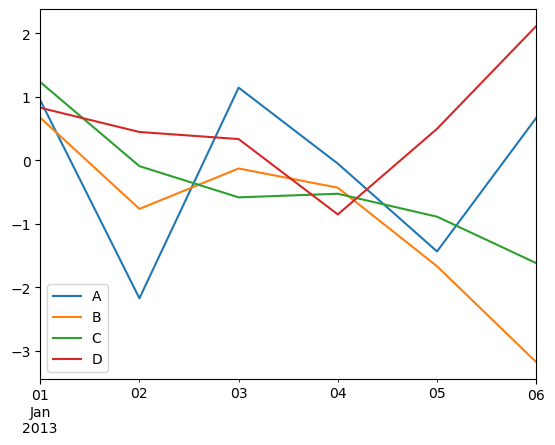

In [99]:
pdf.plot()